# Overview
In this lab, we will try to predict malicious network attacks. 
There are many different types of attacks, but for this lab we
will only try to predict normal vs malicious. This is the same
data that we used in Lab 2.


# Data
The data comes from 
[KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).
The data contains several million network connections from a lab
environment. The purpose of this data was to help build a network
intrusion detector. 

The full dataset is very large, consisting of nearly 5 million rows. You may wish
to use the 10% subset of the data while writing your code to speed up
model training. Once your code is proper, you can remove the
subset and instead use the entire dataset.

Download the files `kddcup.data_10_percent.gz` and `kddcup.names` from the website.

# Preprocessing
We will clean the data in the same manner as in Lab 2. 

## Imports
For this lab we will be using functions from the popular 
[scikit-learn project](https://scikit-learn.org/stable/index.html). 
Import the functions shown below. We will use these later in the lab.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn import metrics

## Read in file names

In [2]:
# load txt file
names = pd.read_csv('data/kddcup.names', header=None, delimiter=':',skiprows=1)

# make column 0 into a list
name_list = names[0].tolist()

# add the last column with type
name_list.append('type')

## Read in main dataframe

In [3]:
# use the column names
netattacks = pd.read_csv('data/kddcup.data_10_percent_corrected', names=name_list, header=None, index_col=None)

# netattacks.head()
# netattacks.describe(include='all')

## Create labels for binary classification

In [4]:
netattacks['label'] = np.where(netattacks['type'] == 'normal.', 'good', 'bad')
# netattacks['label'].value_counts()

# Segment data
Next, we will create train and test sets of the data. We will
fit the model with the training set, and use the test set to evaluate the model.
We will do a 75/25 split (75% will be training data).

The `train_test_split` function in the `sklearn.model_selection` package makes this simple.
Notice that there are two return values from this function.

In [5]:
train, test = train_test_split(netattacks, test_size=0.25)
print("Rows in train:", len(train))
print("Rows in test:", len(test))

Rows in train: 370515
Rows in test: 123506


# Train model
We will use the training data to train the model. You can 
use all of the variables, or just a small subset of the predictors
(in this case, just two values for prediction). 

The function we will use is `tree.DecisionTreeClassifier()` from
the `sklearn` package. The full documentation on how to use
this classifier is [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontree#sklearn.tree.DecisionTreeClassifier)

Unfortunately, the `DecisionTreeClassifier()` in `sklearn` does not accept categorical
variables without some data conversion. We will leave that aside 
for this lesson and use only continuous variables. For more information 
on this issue, see the [bug report](https://github.com/scikit-learn/scikit-learn/pull/12866).

In [6]:
# define new tree
dt = tree.DecisionTreeClassifier()
# train the model using a list of column names
pred_vars = ['src_bytes', 'dst_bytes']
# The value we are trying to predict is 'label'
dt.fit(train.loc[:, pred_vars], train['label'])
# tree.plot_tree(dt)

DecisionTreeClassifier()

Training the model is relatively fast, and should take less than a minute on most machines
when using the 10% data. If using the full dataset, it may take longer. 

# Predict labels for test data
The next step is to evaluate the performance of the model. The first step is
running the predicted data through the model. We will receive a list of 
the predicted label for each row. You must use the same columns 
for prediction as you used for training.

In [7]:
predicted = dt.predict(test.loc[:, pred_vars])
print(predicted[:5]) # show first five predictions

['good' 'bad' 'good' 'good' 'bad']


We can get look at the breakdown of each predicted label.
The description of the code below is 
[here](https://stackoverflow.com/questions/2600191/how-can-i-count-the-occurrences-of-a-list-item).

In [8]:
from collections import Counter
# count test data
test_labels_stats = Counter(test['label'])
print("Labels in the test data:", test_labels_stats)

# count predicted
predicted_labels_stats = Counter(predicted)
print("Labels in the predictions:", predicted_labels_stats)

Labels in the test data: Counter({'bad': 99089, 'good': 24417})
Labels in the predictions: Counter({'bad': 100421, 'good': 23085})


# Model Stats

You can view the many types of model statistics on the 
[scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).
Most of the model statistics are based on a comparison of the *predicted* label for 
each row and its *true* label in the original data.

## Confusion Matrix
First, let's see the confusion matrix. We can use the 
`sklearn.metrics` import to generate this. We specify
the labels such that `good` is the positive class
and `bad` is the negative class. 
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).


In [9]:
metrics.confusion_matrix(y_true=test['label'], y_pred=predicted, labels=['good', 'bad'])

array([[23071,  1346],
       [   14, 99075]])

This ouptut is quite ugly. We can use the 
`plot_conufsion_matrix` function to generate a 
nice-looking plot of the matrix.

/Users/samueldemero/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


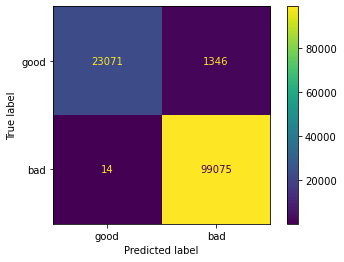

In [10]:
metrics.plot_confusion_matrix(dt, test.loc[:, pred_vars], test['label'], labels=['good', 'bad'])
plt.show()

We can see that this model rarely predicted traffic as `good`. When it 
did predict traffic as `good`, it was usually correct.

## Accuracy
Next, let's compute the simple accuracy score. We are hoping for accuracy that is 
better than the baseline rate. In this case, if we predicted
all `bad`, accuracy would be around 80%! This sounds high, but it is only the baseline
level to clear. First, use the `Counter` 
we created early (this is a
[dictionary](https://www.w3schools.com/python/python_dictionaries.asp)).

In [11]:
# compute baseline accuracy (predict all bad)
baseline = test_labels_stats['bad'] / (test_labels_stats['good'] + test_labels_stats['bad'])
print("Baseline accuracy is:", baseline)

# compute the observed accuracy
acc = metrics.accuracy_score(test['label'], predicted)
print("Observed accuracy is:", acc)

Baseline accuracy is: 0.8023011027804318
Observed accuracy is: 0.9889883892280537


The baseline for `bad` traffic in this dataset is just over 80%. By predicting everything is `bad`, we could achieve that level of accuracy. Of course, this would be a totally useless model. 

The `classification` report gives us other important staistics,
like `precision`, `recall`, and `F1 score`.

In [12]:
result = metrics.classification_report(test['label'], predicted, digits=4)
print(result)

              precision    recall  f1-score   support

         bad     0.9866    0.9999    0.9932     99089
        good     0.9994    0.9449    0.9714     24417

    accuracy                         0.9890    123506
   macro avg     0.9930    0.9724    0.9823    123506
weighted avg     0.9891    0.9890    0.9889    123506



If filtering out `bad` traffic was most important, we would focus on that statistic in the table above. 
It blocks over 99.9% of bad traffic (see `recall` for `bad`)! 
However, we want to allow good traffic ***and*** block bad traffic, so this statistic is not enough by itself. 

What is the recall for the `good` class? Would this classifier be suitable to use in a production network?

# Exercises
1. Try with different predictor variables. Does the model improve?
2. Try with different parameters for the tree. The list of adjustable parameters is
   [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontree#sklearn.tree.DecisionTreeClassifier). 
3. (Optional): Try running the models with the full dataset. Report all statistics and your interpretation.
